# Reinforcement Learning in Finite MDPs

In [1]:
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1

The system cannot find the path specified.


## MDPs

In [0]:
import sys
sys.path.insert(0, './mvarl_hands_on/utils')
import numpy as np
from scipy.special import softmax # for SARSA
import matplotlib.pyplot as plt
import json
import math
from cliffwalk import CliffWalk 
from test_env import ToyEnv1

Setting up the environment

In [0]:
env = CliffWalk(proba_succ=0.98)

####################################################################################
# You probably want to test smaller enviroments before
#env = ToyEnv1(gamma=0.95)
####################################################################################

# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s, a, s'] = env.P[s, a, s']
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=1, a=3,s'=2): ", env.reward_func(1,0,2))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward)
    if done:
        break
    state = next_state
print("")

Set of states: range(0, 48)
Set of actions: [0, 1, 2, 3]
Number of states:  48
Number of actions:  4
P has shape:  (48, 4, 48)
discount factor:  0.99

initial state:  36
reward at (s=1, a=3,s'=2):  0.6

random policy =  [3 3 3 1 3 0 3 3 0 3 1 1 1 1 3 0 1 3 0 3 3 2 0 3 0 2 0 2 3 2 1 0 2 1 3 3 0
 2 3 0 3 3 1 0 0 0 0 3]
(s, a, s', r):
36 0 37 0.6
37 2 36 0.0
36 0 37 0.6
37 2 36 0.0



## Value iteration
1. optimal Bellman operator on a provided Q function: $Q_1 = LQ_0, \; Q_0\in \mathbb{R}^{S\times A}$
2. Value Iteration (VI) with $\infty$-norm stopping condition 
3. Evaluating the convergence of the estimate, i.e., plot the value $\|V_n - V^\star\|_{\infty}$

In [0]:
# --------------
# Point 1
# --------------
def bellman_operator(Q0, env):
    # TODO
    V=np.max(Q0,axis=1)
    Q1=np.zeros((env.Ns,env.Na))
    for s in range(env.Ns):
      for a in range(env.Na):
        for s_prime in range(env.Ns):
          Q1[s,a]+= env.P[s,a,s_prime]*(env.reward_func(s,a,s_prime)+env.gamma*V[s])
    greedy_policy=np.argmax(Q1,axis=1)
    #Q1=np.diag(Q1.T[np.argmax(Q1,axis=1)])               
    return Q1, greedy_policy

In [0]:
# --------------
# Point 2
# --------------
def value_iteration(Q0, env, epsilon=1e-5,maxiter=10000):
  Q_history=[Q0]
  Q=Q0
  delta=5
  counter=0
  while (delta>epsilon) and counter<maxiter:
    counter+=1
    Q, greedy_policy=bellman_operator(Q,env)
    delta=np.max(np.abs(Q-Q_history[-1]))
    Q_history+=[Q]
  if counter>= maxiter : 
    print('algo didn"t converge')
  return Q, greedy_policy, Q_history

Text(0.5, 1.0, 'Q-learning: Convergence of Q')

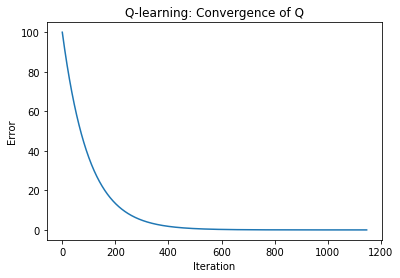

In [0]:
# --------------
# Point 3
# --------------
with open("./mvarl_hands_on/data/Q_opts.json", "r") as fp:
    Qopts = json.load(fp)
Qstar = Qopts["{}_{}".format(type(env).__name__,env.gamma)]
Q0=np.zeros((env.Ns,env.Na))
Q, greedy_policy, Q_history = value_iteration(Q0,env,maxiter=10000)
norm_values=[np.max(np.abs(Qn-Q)) for Qn in Q_history]

plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")

In [0]:
state = env.reset()
env.render()
for i in range(50):
    action = greedy_policy[state]
    state, reward, done, _ = env.step(action)
    env.render()
    if done : 
      break

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+------------

## Q learning Algorithm
Q learning is a model-free algorithm for estimating the optimal Q-function online.
It is an off-policy algorithm since the samples are collected with a policy that is (potentially) not the one associated to the estimated Q-function.

1. Implementation of  Q learning with $\epsilon$-greedy exploration.
what we'll do is : 
  - Plot the error in Q-functions over iterations
  - Plot the sum of rewards as a function of iteration


$\epsilon$-greedy policy:
$$
\pi(s) = \begin{cases}
\max_a Q(s,a) & \text{w.p.} 1- \epsilon\\
\text{random action} & \text{w.p.} \epsilon
\end{cases}
$$

In [0]:
# ---------------------------
# Q-Learning
# ---------------------------
# suggested interface
# you can change it!
class QLearning:
    """
    Q learning with epsilon-greedy exploration
    """
    def __init__(self,Q0,env,epsilon):
        self.env=env
        """initialisation of Q function, and Epsilon is a 
        param of the epsilon greedy policy we'll use as an exploration policy """
        self.Q = Q0
        self.epsilon=epsilon
    def epsilon_greedy_policy(self,s):
      """Create epsilon-Gready Policy"""
      A = np.ones(self.env.Na, dtype=float) * self.epsilon / self.env.Na
      best_action = np.argmax(self.Q[s])
      A[best_action] += 1-self.epsilon
      return A
    def sample_action(self, state):
      action_probs = self.epsilon_greedy_policy(state)
      action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
      next_state, reward, done, _ = self.env.step(action)
      return next_state,reward,done,action            
    def update(self, state, action, next_state, reward,alpha):
      best_next_action = np.argmax(self.Q[next_state])    
      td_target = reward + self.env.gamma * self.Q[next_state][best_next_action]
      delta_t = td_target - self.Q[state][action]
      self.Q[state][action] += alpha * delta_t


In [0]:

# --------------
# Point 1
# --------------
# Number of Q learning steps
#max_steps = int(1e5)  

Q0 = np.zeros((env.Ns, env.Na))
# Use the previous code to verify the correctness of q learning
Q_opt, pi_opt,Q_hist = value_iteration(Q0, env, epsilon=1e-8)


+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
None
optimal policy:  [2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 0 0 0 0 0 0 0 0 0 0 0]
    est policy: [3 2 2 2 0 0 3 0 0 2 2 2 3 0 0 0 0 3 3 3 0 0 2 1 3 0 3 3 2 2 3 2 3 0 2 0 3
 3 3 3 3 3 3 3 3 3 3 0]


Text(0.5, 1.0, 'Q-learning: Convergence of Q')

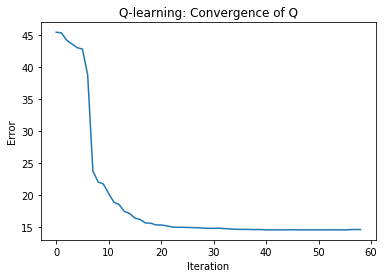

In [0]:

# main algorithmic loop
env.reset()
Q0 = np.zeros((env.Ns, env.Na))
norm_values = []
t = 1
epsilon=1
alpha=0.5
ql=QLearning(Q0,env,epsilon)
max_steps = 60
rewards=[]
while t < max_steps:
    state = ql.env.reset()
    done=False
    R=0
    while not(done):
      next_state,reward,done,action=ql.sample_action(state)
      ql.update(state, action, next_state, reward,alpha)
      state=next_state
      R+=reward
    rewards.append(R)
    norm_values.append(np.abs(ql.Q - Q_opt).mean())
    t = t + 1
    alpha=1/(t**0.51)
    """we slowly decrease epsilon so we have more exploration 
    as we start but more exploitation as we go """
    if t%2==0:
      ql.epsilon*=0.95
    
print(env.render())
print("optimal policy: ", pi_opt)
greedy_policy = np.argmax(ql.Q, axis=1)
print("    est policy:", greedy_policy)


plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")

# how confident are you in the performance of the algorithm? maybe a single run is not enough

Text(0.5, 1.0, 'Q-learning: Rewards sum ')

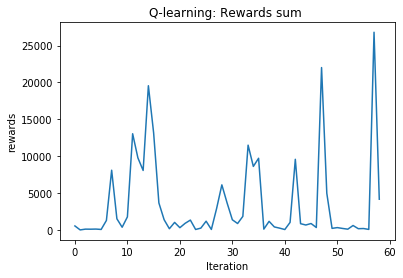

In [0]:
plt.plot(rewards)
plt.xlabel('Iteration')
plt.ylabel('rewards')
plt.title("Q-learning: Rewards sum ")

Text(0.5, 1.0, 'Q-learning: Rewards Cum sum ')

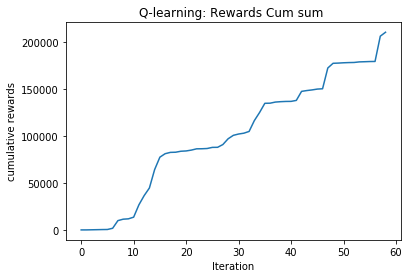

In [0]:
plt.plot(np.cumsum(rewards))
plt.xlabel('Iteration')
plt.ylabel('cumulative rewards')
plt.title("Q-learning: Rewards Cum sum ")